In [1]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.6.8
import os

from IPython.display import Image
from IPython.display import display

# numpy  1.19.5
import numpy as np

# pandas  0.25.3
import pandas as pd

# scikit-learn  0.22
from scipy import interp
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import auc, confusion_matrix,  f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# cycler 0.10.0
from cycler import cycler

# matplotlib  3.1.2
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
plt = matplotlib.pyplot

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
# from lib import *

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

In [2]:
#load the data
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                   'arrhythmia/arrhythmia.data', header=None, sep=',', engine='python')

display(data.head(3))

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


In [3]:
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))


452 rows and 280 columns


In [4]:
np.unique(data[len(data.columns)-1])


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16], dtype=int64)

In [5]:
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)
data = data.drop(len(data.columns)-2, axis=1)

In [6]:
data.groupby(['arrhythmia']).size()


arrhythmia
0    245
1    207
dtype: int64

In [7]:
data = data._get_numeric_data()
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 275 columns


In [8]:
data.head(3)


,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,1
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,1
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,1


In [9]:
X = data.iloc[:, :-1]  # The first to second-last columns are the features
y = data.iloc[:, -1].values   # The last column is the ground-truth label
print(np.unique(y))
print(X.shape)

[0 1]
(452, 274)


In [10]:
# splitting the dataset to training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20181004)

In [37]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [52]:
class LogisticRegression(object):

    def __init__(self, eta=0.05, n_epoch=100, random_state=1):
        self.eta = eta
        self.n_epoch = n_epoch
        self.random_state = random_state
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_epoch):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = self.loss(output, y)
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def loss(self, output, y):
        """Calculate loss"""
        # TODO
        loss = -y * np.log(output) - (1 - y) * (np.log(1 - output))
        return loss.mean()
    
    def activation(self, z):
        """Compute logistic sigmoid activation"""
        # TODO
        return 1.0 / (1.0 + np.exp(-z))

    def predict(self, X):
        """Return class label after unit step"""
        # TODO
        y = self.net_input(X)
        y = self.activation(y)
        return np.where(y > 0.5, 1, 0)


In [53]:
from sklearn.metrics import accuracy_score

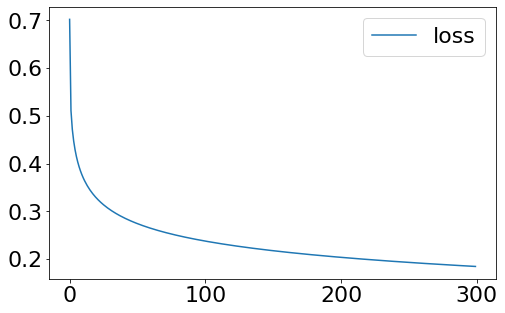

acc = 0.7912087912087912


In [54]:
epoch = 300
lr = 1e-3

model = LogisticRegression(eta=lr, n_epoch=epoch)
model.fit(X_train_std, y_train)
y_test_pred = model.predict(X_test_std)
acc = accuracy_score(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(np.arange(epoch), model.cost_, label=f'loss')
ax.legend()
plt.show()
print(f'acc = {acc}')

In [55]:
from sklearn.metrics import confusion_matrix
def compute_f1_score(confmat):
    tp = float(confmat[0][0])
    fp = float(confmat[1][0])
    fn = float(confmat[0][1])
    
    pre = tp / (tp + fp)
    rec = tp / (tp + fn)
    
    return 2 * pre * rec / (pre + rec)

f1 score = 0.7764705882352941


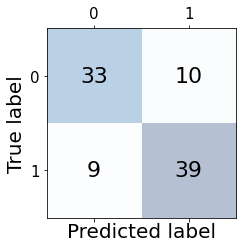

In [56]:
fig, ax = plt.subplots(figsize=(4, 4))
confmat = confusion_matrix(y_test, y_test_pred)
f1s = compute_f1_score(confmat)
print(f'f1 score = {f1s}')

ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('./output/fig-logistic-regression-confusion-2.png', dpi=300)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()